In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df_raw = pd.read_csv('2015_SWAT/Physical/SWaT_Dataset_Normal_v1.csv', header = 1)
df_raw_attack = pd.read_csv('2015_SWAT/Physical/SWaT_Dataset_Attack_v0.csv')

In [3]:
df_raw_attack.columns = df_raw.columns

In [ ]:
#df_raw.shape, df_raw_attack.shape

In [ ]:
#df_raw.info()

In [4]:
%%capture
df_raw['Timestamp'] = df_raw[' Timestamp']
df_raw.pop(' Timestamp')

In [5]:
%%capture
df_raw_attack['Timestamp'] = df_raw_attack[' Timestamp']
df_raw_attack.pop(' Timestamp')

In [6]:
df_raw['Timestamp'] = pd.to_datetime(df_raw.Timestamp)
move_to_1 = df_raw.pop('Timestamp')
df_raw.insert(0, 'Timestamp', move_to_1)

In [7]:
df_raw_attack['Timestamp'] = pd.to_datetime(df_raw_attack.Timestamp)
move_to_1 = df_raw_attack.pop('Timestamp')
df_raw_attack.insert(0, 'Timestamp', move_to_1)

In [8]:
Label = []
for i in range(len(df_raw_attack)):
    if df_raw_attack['Normal/Attack'][i] == 'Normal':
        Label.append(0)
    else:
        Label.append(1)

df_raw_attack['Label'] = Label

In [206]:
df_raw_attack.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack,Label
0,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal,0
1,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal,0
2,2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal,0
3,2015-12-28 10:00:03,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal,0
4,2015-12-28 10:00:04,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal,0


# Common variables in Normal and Attack data sets that have only 1 unique value:  P202, P401, P404, P502, P601, P603

# df_raw and df_raw_attack are original except that time stamp is formated and moved to first column

In [9]:
df = df_raw.copy()

In [10]:
%%capture
# remove first 5 hours as this is the time it takes the system to equilibrate
# remove Label column

df = df[df['Timestamp'] > '22/12/2015 9:30:00 PM']
Timestamp = df.pop('Timestamp')
df.pop('Normal/Attack')

## The data set "df" is the prepared version of data.  It has no attacks.  First 5 hours removed (equilibration time of system).  Timestamp column removed.  'Timestamp' array has time stamp for "df"

## -------------------------------------------------------------------------------------------------

## Scale df to prepare for kmeans.  This data set will be 'df_scaled'

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns

# kmeans using all variables from 'df_scaled', 1 cluster for Normal

In [12]:
kmeans = KMeans(n_clusters = 1, random_state = 22).fit(df_scaled)

In [13]:
norm_center = kmeans.cluster_centers_

### Using cluster generated from Normal dataset, find Euclidean distance

In [14]:
dist = np.linalg.norm(norm_center)

In [84]:
%%capture
df_attack = df_raw_attack.copy()
df_attack.pop('Normal/Attack')
Timestamp_attack = df_attack.pop('Timestamp')

In [85]:
df_attack_scaled = pd.DataFrame(scaler.fit_transform(df_attack))
df_attack_scaled.columns = df_attack.columns

In [17]:
df_dist = df_attack_scaled.copy()
df_dist['eucldist'] = np.apply_along_axis(np.linalg.norm, 1, df_attack_scaled)
df_dist['center'] = dist
df_dist['delta'] = abs(df_dist['eucldist'] - df_dist['center'])

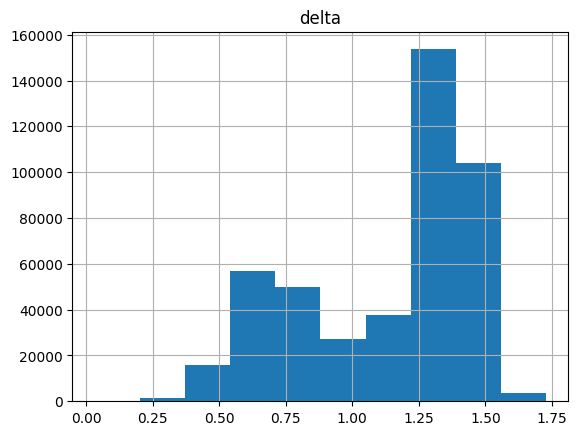

In [18]:
df_dist.hist('delta')
plt.show()

In [19]:
pred_attack = []
for i in range(len(df_dist)):
    if df_dist['delta'][i] > 1.57:
        pred_attack.append(1)
    else:
        pred_attack.append(0)

In [20]:
df_dist['pred_attack'] = pred_attack
df_dist['Attack']=df_raw_attack['Label']
conf_matrix_c1 = pd.crosstab(df_dist['Attack'], df_dist['pred_attack'], rownames = ['Actual'], colnames = ['Predicted'])
print(conf_matrix_c1)

Predicted       0     1
Actual                 
0          395298     0
1           51495  3126


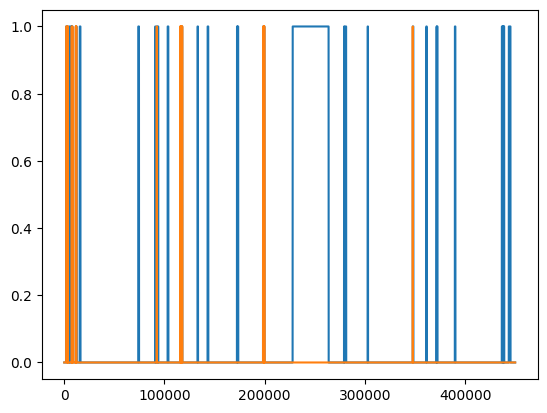

In [21]:
df_dist['Label'].plot()
df_dist['pred_attack'].plot()
plt.show()

## Use CUSUM on Attack data set

In [78]:
from __future__ import division, print_function
import warnings
import numpy as np

tai_list = []
ta_list = []
def detect_cusum(x, threshold=0.5, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.
    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).
 
    [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    """




    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        """        
        # s is distance measure, s = (measurements up to t) - (measurements up to t-1)

        # alarm is given when the stopping rule has been met and theta has exceeded the threshold
        # gt is auxillary test statistic used for alarms using threshold. Alarm if gt = theta > h.
        
        # To prevent positive drifts, eventually yielding a false alarm, a small drift term v is subtracted at each time instant. 
        # To prevent a negative drift, which would increase the time to detection after a change, the test statistic is reset to 0 each time in becomes less than a negative constant a.
        """
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start. index of when the change started.
            gp[i], gn[i] = 0, 0      # reset alarm


    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)
    
    print("tai",tai)
    tai_list.append(tai)
    ta_list.append(ta)
    return ta, tai, taf, amp

def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""
    
    #print("-----------------------------------", str(df_attack_scaled.columns[j]), "-----------------------------------")
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
#             _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
            _, (ax1) = plt.subplots(1, 1, figsize=(8, 4))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Seconds', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
#         ax2.plot(t, gp, 'y-', label='+')
#         ax2.plot(t, gn, 'm-', label='-')
#         ax2.set_xlim(-.01*x.size, x.size*1.01-1)
#         ax2.set_xlabel('Data #', fontsize=14)
#         ax2.set_ylim(-0.01*threshold, 1.1*threshold)
#         ax2.axhline(threshold, color='r')
#         ax1.set_ylabel('Amplitude', fontsize=14)
#         ax2.set_title('Time series of the cumulative sums of ' +
#                       'positive and negative changes')
#         ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

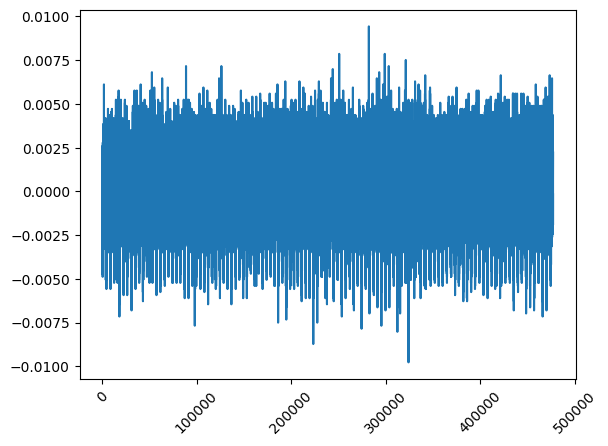

In [210]:
plt.plot(df_scaled['LIT301'].diff())
plt.xticks(rotation = 45)
plt.show()

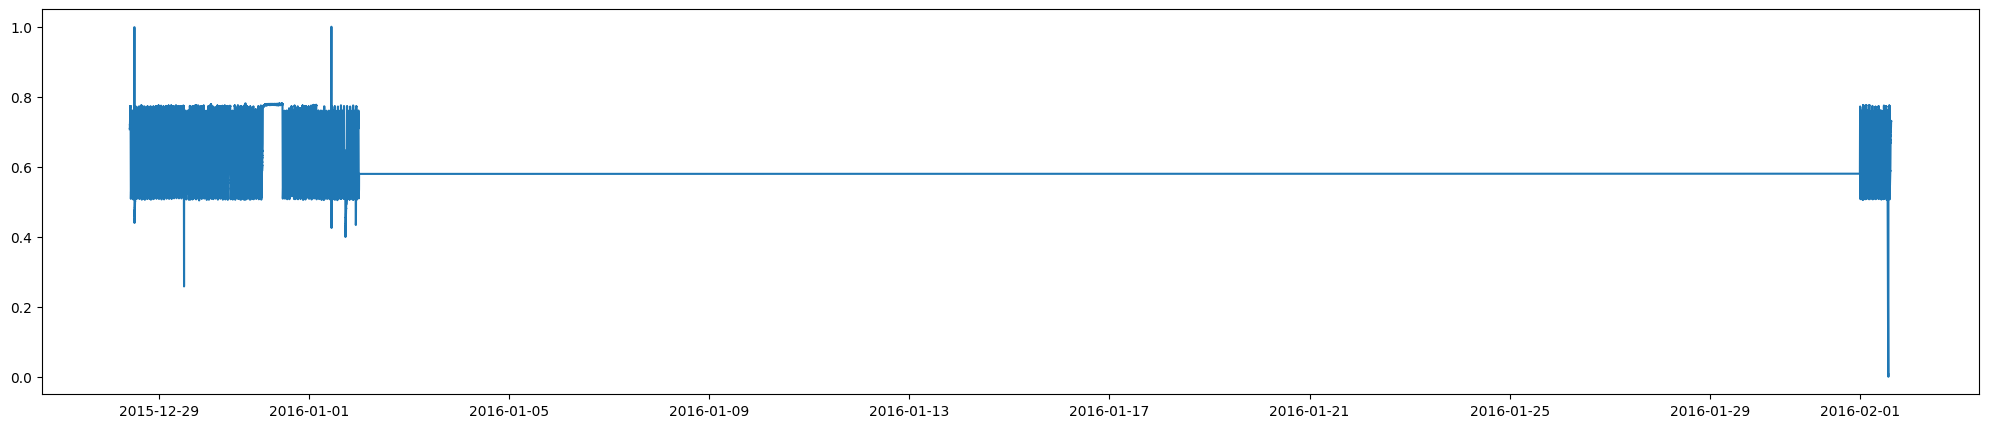

In [212]:
plt.figure(figsize = (25, 5))
plt.plot(Timestamp_attack,df_attack_scaled['LIT301'])
#plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

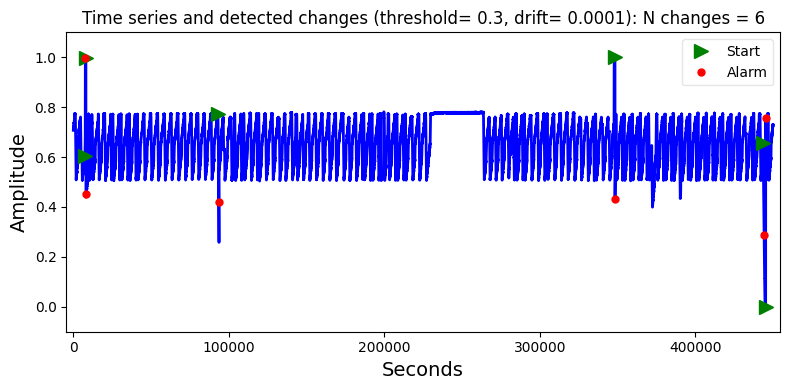

tai [  7448   8112  93013 348314 443537 445190]


(array([  7685,   8113,  93554, 348315, 444218, 445191]),
 array([  7448,   8112,  93013, 348314, 443537, 445190]),
 array([], dtype=int64),
 array([], dtype=float64))

In [119]:
detect_cusum(x = df_attack_scaled['LIT301'], threshold = 0.3, drift = 0.0001)

In [224]:
Timestamp_attack[7448], Timestamp_attack[8112], Timestamp_attack[93013], Timestamp_attack[348314], Timestamp_attack[443537], Timestamp_attack[445190]

(Timestamp('2015-12-28 12:04:08'),
 Timestamp('2015-12-28 12:15:12'),
 Timestamp('2015-12-29 11:50:13'),
 Timestamp('2016-01-01 10:46:35'),
 Timestamp('2016-02-01 13:13:38'),
 Timestamp('2016-02-01 13:41:11'))

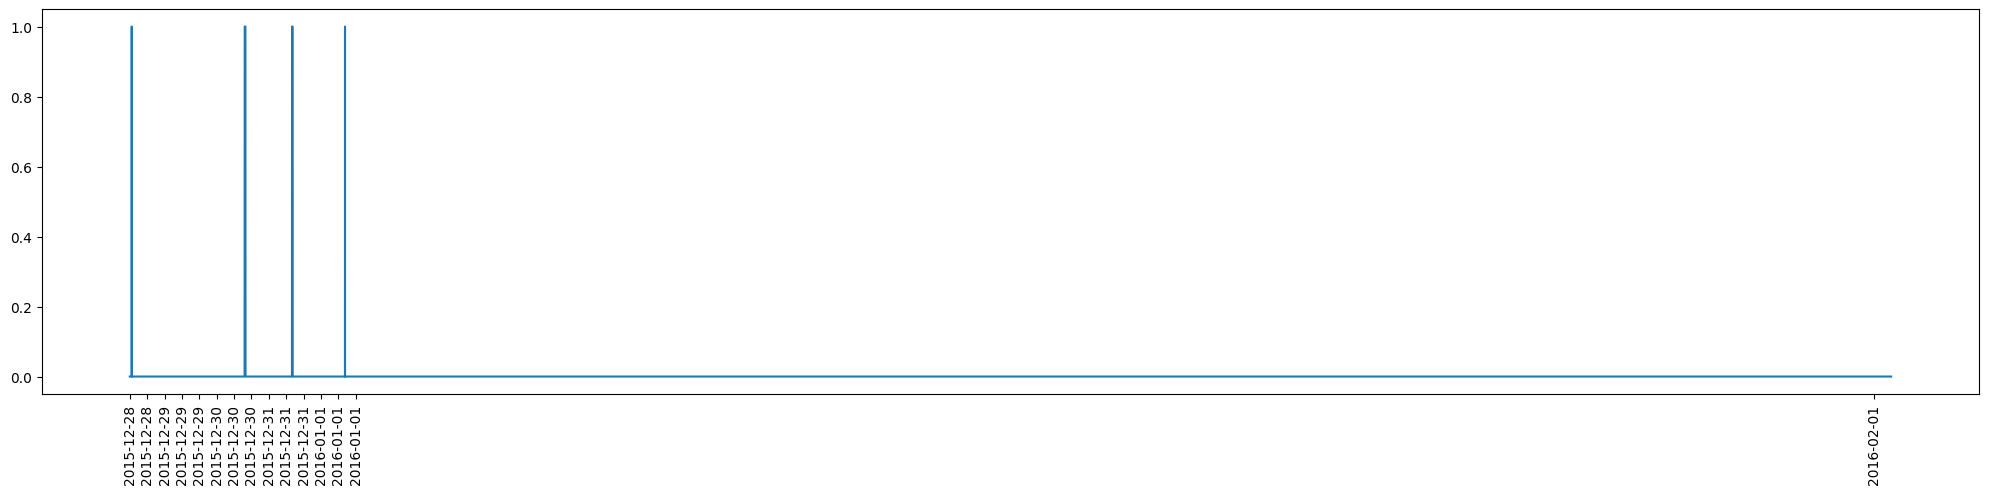

In [125]:
plt.figure(figsize = (25, 5))
plt.plot(Timestamp_attack,df_attack_scaled['P102'])
plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

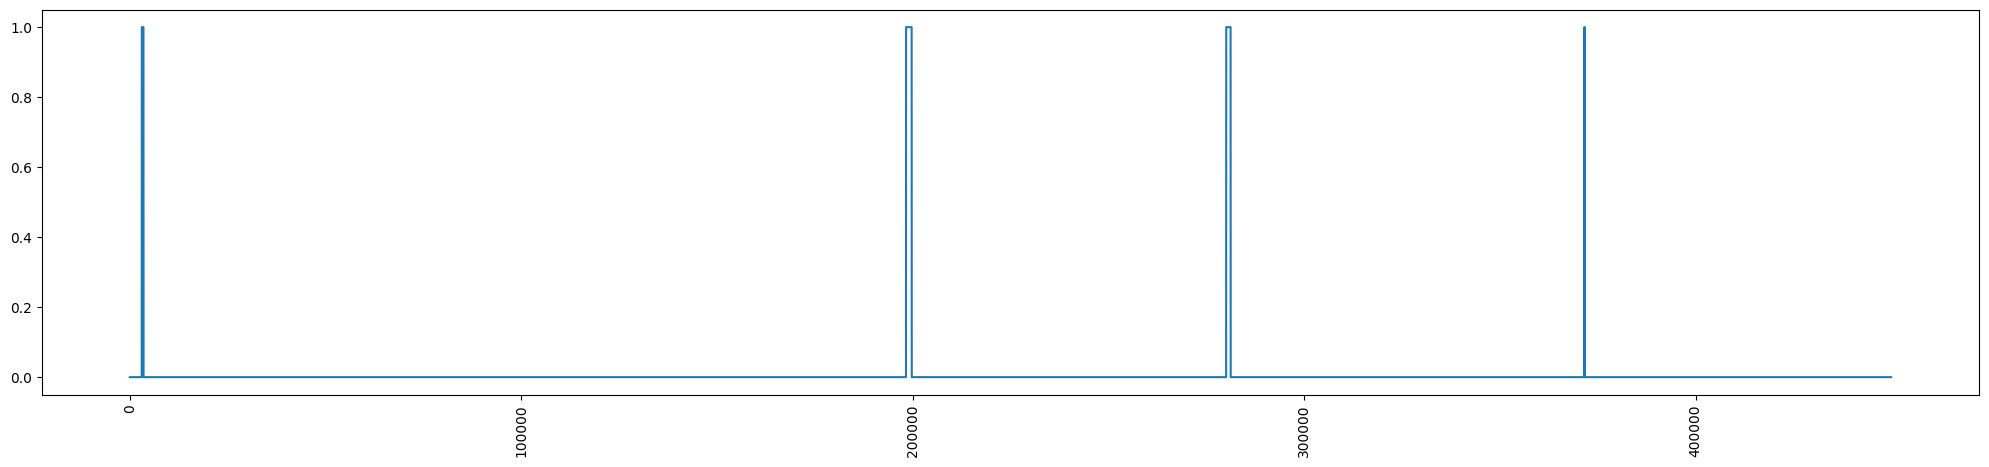

In [203]:
plt.figure(figsize = (25, 5))
plt.plot(df_attack_scaled['P102'])
plt.xticks(rotation = 'vertical')
plt.show()

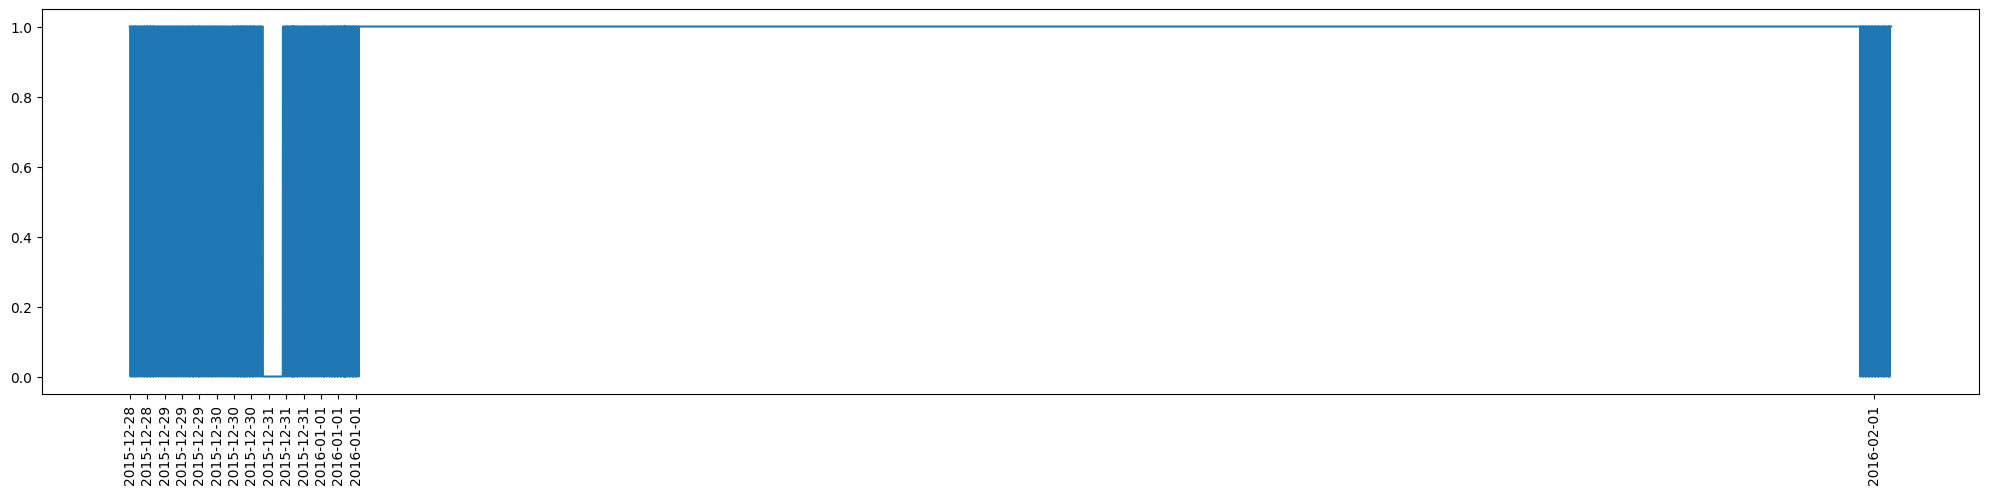

In [126]:
plt.figure(figsize = (25, 5))
plt.plot(Timestamp_attack,df_attack_scaled['P101'])
plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

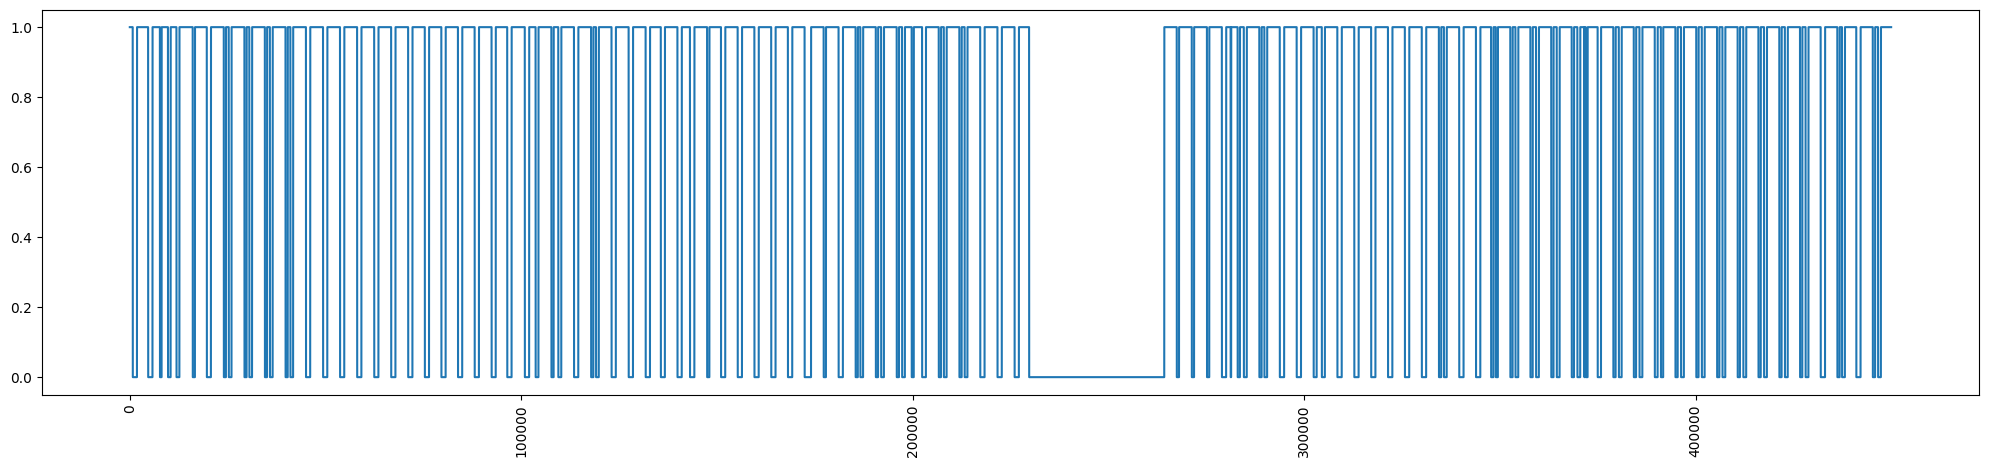

In [205]:
plt.figure(figsize = (25, 5))
plt.plot(df_attack_scaled['P101'])
plt.xticks(rotation = 'vertical')
plt.show()

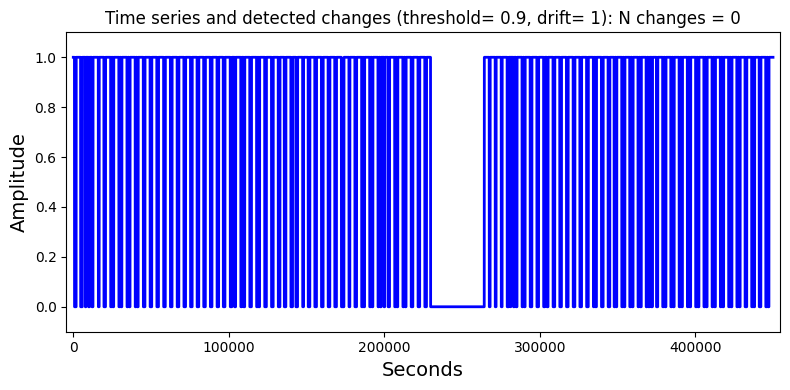

tai []


(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=float64))

In [229]:
detect_cusum(x = (df_attack_scaled['P101']), threshold = 0.9, drift = 1)

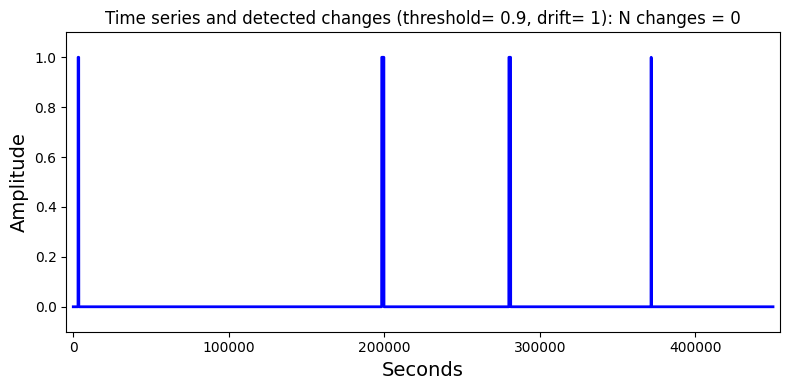

tai []


(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=float64))

In [231]:
detect_cusum(x = (df_attack_scaled['P102']), threshold = 0.9, drift = 1)

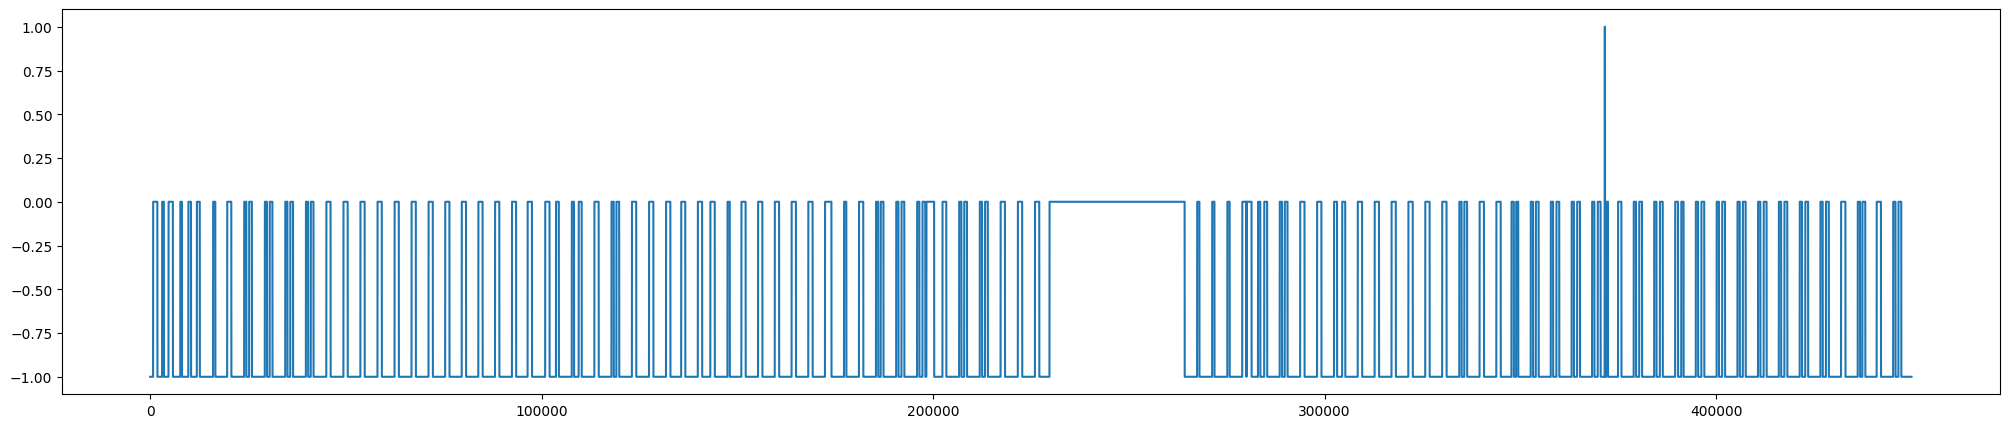

In [147]:
plt.figure(figsize = (25, 5))
plt.plot(df_attack_scaled['P102'] - df_attack_scaled['P101'])
#plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

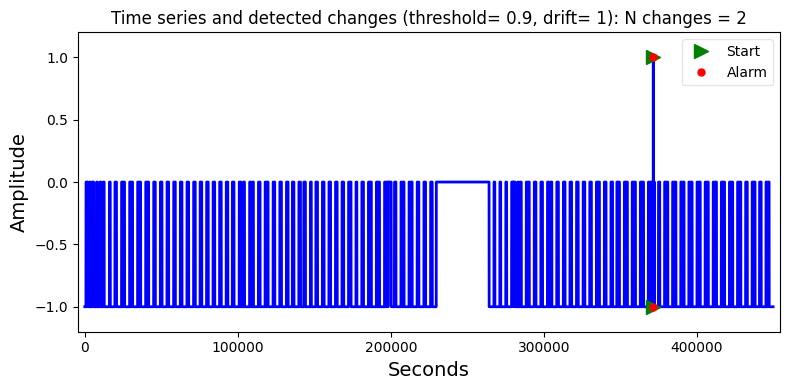

tai [371518 371617]


(array([371519, 371618]),
 array([371518, 371617]),
 array([], dtype=int64),
 array([], dtype=float64))

In [144]:
detect_cusum(x = (df_attack_scaled['P102'] - df_attack_scaled['P101']), threshold = 0.9, drift = 1)

In [245]:
Timestamp_attack[371518],Timestamp_attack[371617]

(Timestamp('2016-01-01 17:13:19'), Timestamp('2016-01-01 17:14:58'))

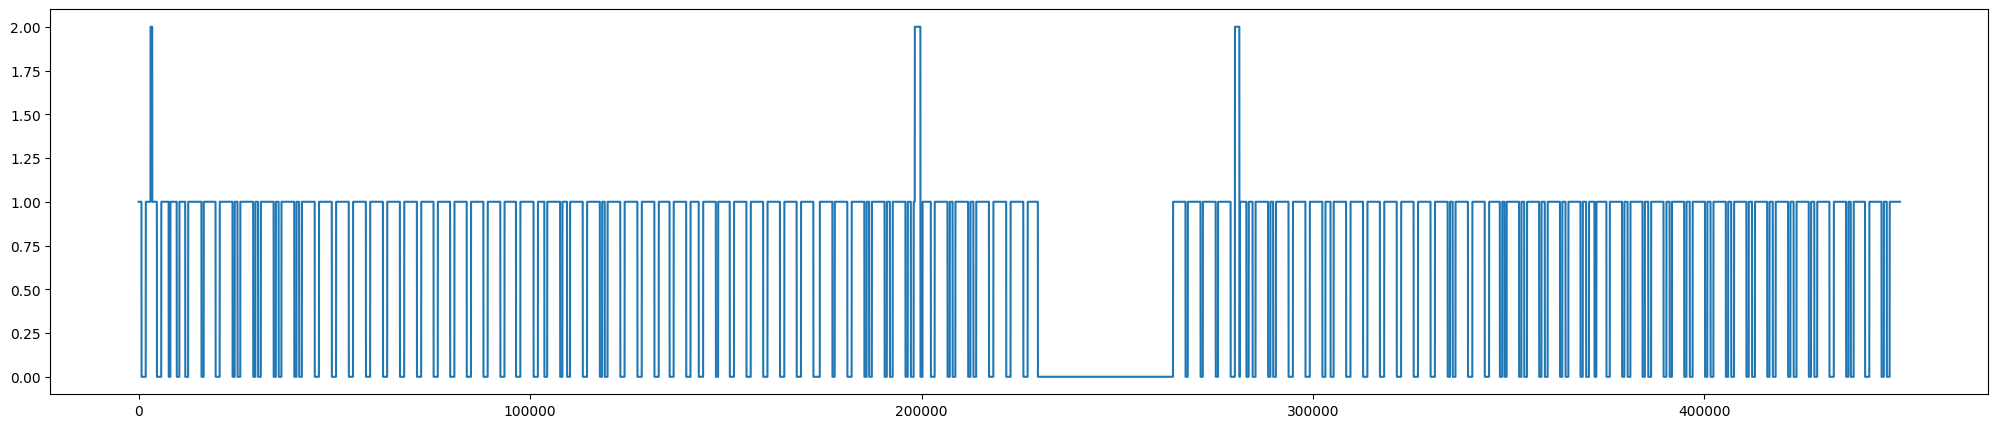

In [149]:
plt.figure(figsize = (25, 5))
plt.plot(df_attack_scaled['P102'] + df_attack_scaled['P101'])
#plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

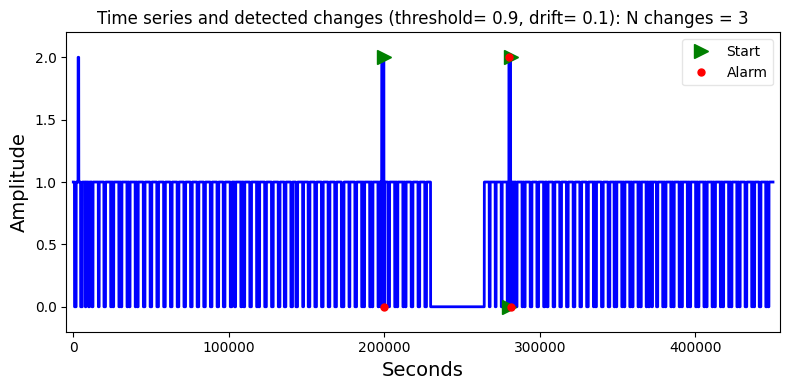

tai [199715 280042 281184]


(array([199716, 280047, 281185]),
 array([199715, 280042, 281184]),
 array([], dtype=int64),
 array([], dtype=float64))

In [242]:
detect_cusum(x = (df_attack_scaled['P102'] + df_attack_scaled['P101']), threshold = 0.9, drift = 0.1)

In [244]:
Timestamp_attack[199715], Timestamp_attack[280042], Timestamp_attack[281184] 

(Timestamp('2015-12-30 17:28:35'),
 Timestamp('2015-12-31 15:47:22'),
 Timestamp('2015-12-31 16:06:24'))

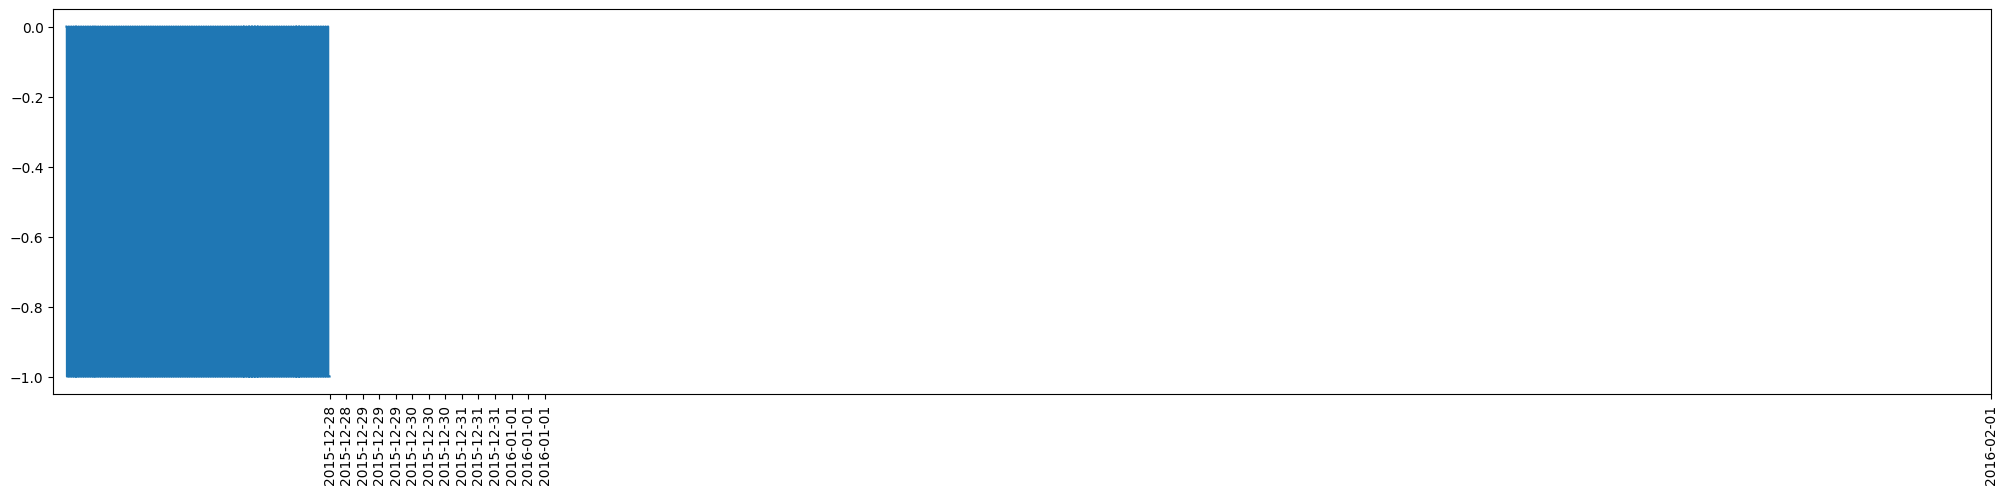

In [132]:
plt.figure(figsize = (25, 5))
plt.plot(Timestamp,(df_scaled['P102'] - df_scaled['P101']))
plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

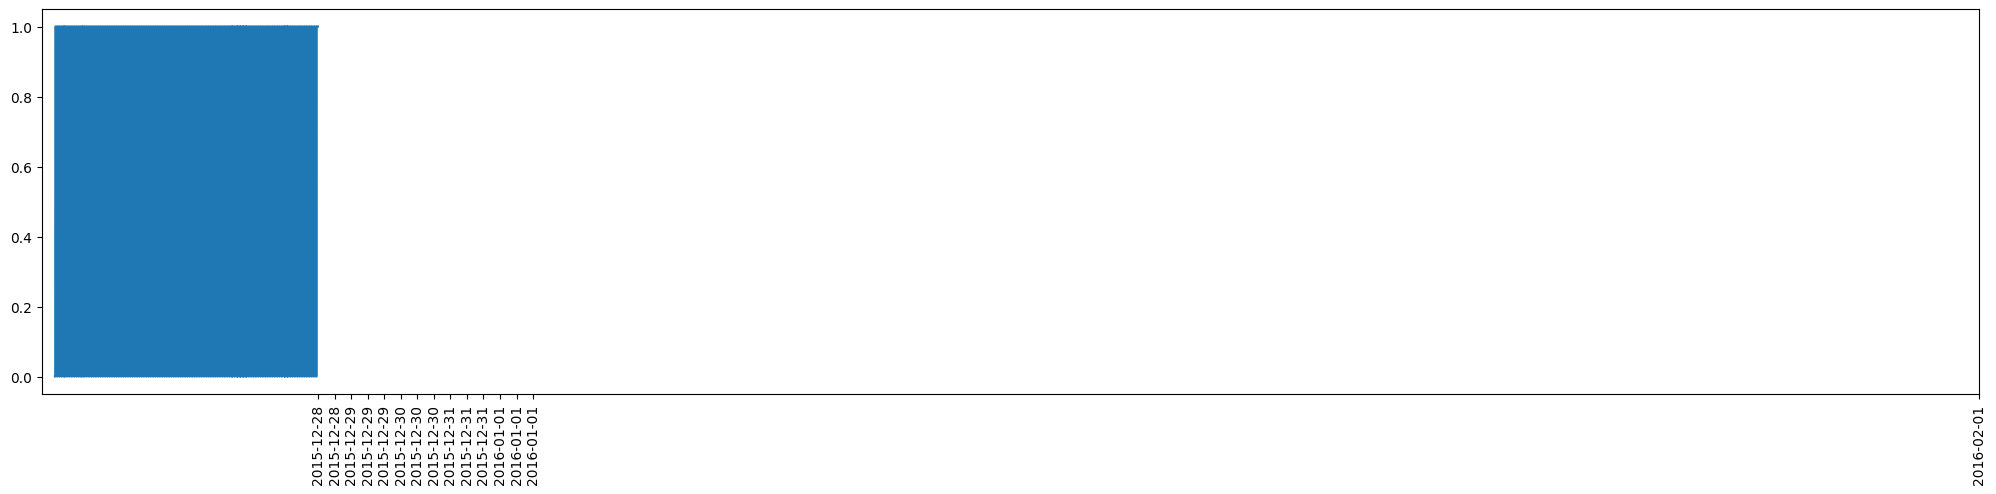

In [133]:
plt.figure(figsize = (25, 5))
plt.plot(Timestamp,(df_scaled['P102'] + df_scaled['P101']))
plt.xticks(Timestamp_attack[::30000],rotation = 'vertical')
plt.show()

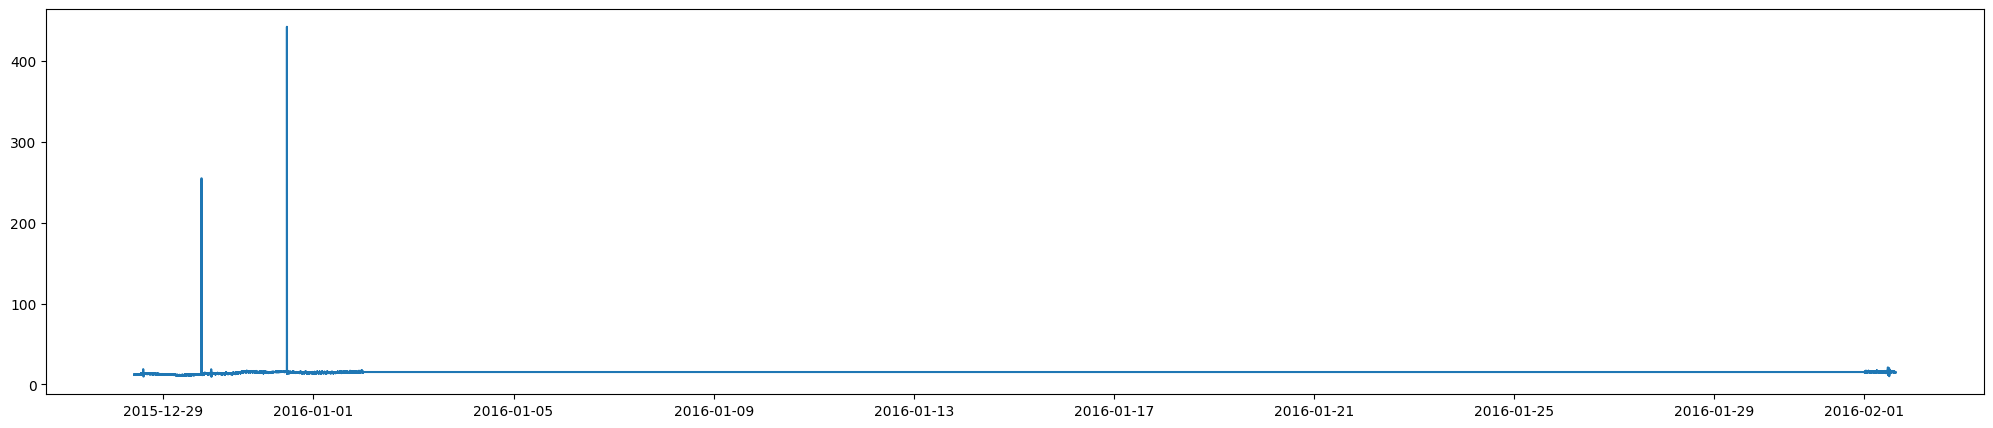

In [182]:
#plt.plot(df_scaled['AIT504'])
plt.figure(figsize = (25, 5))
plt.plot(Timestamp_attack,df_attack['AIT504'])
plt.show()

In [81]:
ta_list

[array([  2693,   5164,  11102,  13349,  16628,  17321,  21395,  25242,
         25930,  26662,  30514,  31912,  37167,  41016,  46754,  49934,
         51128,  67332,  68530,  75930,  80156,  81357,  84394,  85590,
         94146,  98199, 102683, 104270, 105053, 108939, 110894, 118402,
        119090, 120477, 123617, 124814, 127984, 132346, 133547, 141670,
        143700, 144888, 148036, 152779, 160119, 161319, 165623, 168678,
        174685, 178500, 182822, 187344, 191815, 197159, 197924, 198620,
        207203, 207893, 208591, 209320, 213163, 214649, 223414, 226563,
        264912, 268004, 268683, 272532, 276410, 281205, 285987, 289783,
        291196, 299847, 302970, 310249, 313355, 314567, 330596, 334965,
        341368, 344435, 354603, 355337, 358349, 359023, 360608, 365899,
        375039, 379528, 380212, 385438, 387045, 390282, 392890, 393527,
        395419, 402951, 411289, 411975, 413562, 421921, 422612, 423425,
        424180, 427888, 428696, 429456, 433707, 436750, 438169, 

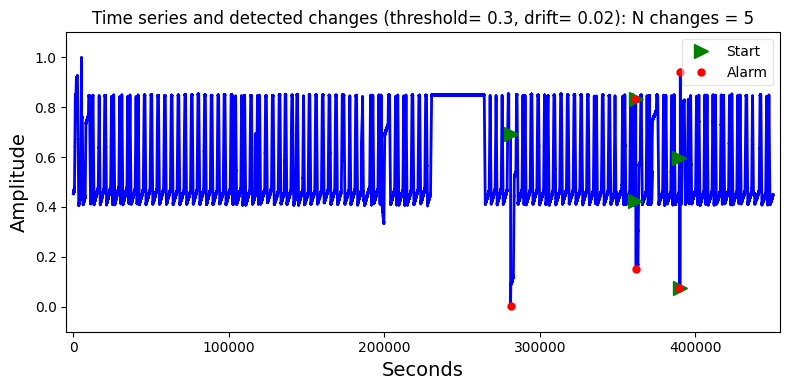

tai [281184 361242 361673 389745 390261]


(array([281185, 361243, 361674, 389746, 390262]),
 array([281184, 361242, 361673, 389745, 390261]),
 array([], dtype=int64),
 array([], dtype=float64))

In [55]:
detect_cusum(x = df_attack_scaled['LIT101'], threshold = 0.3, drift = 0.02)

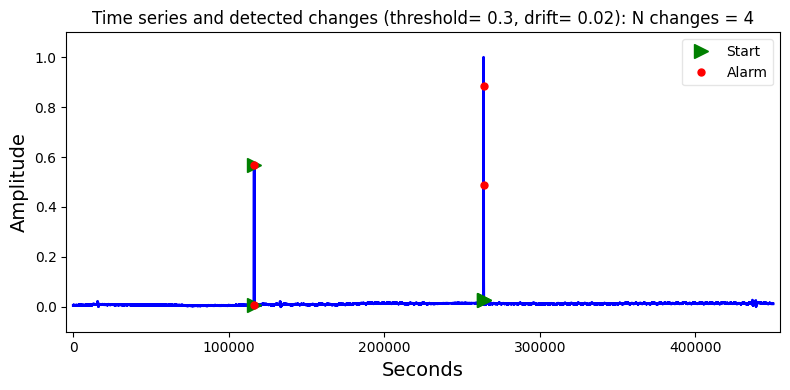

tai [116122 116514 263801 263801]


(array([116123, 116515, 263806, 263810]),
 array([116122, 116514, 263801, 263801]),
 array([], dtype=int64),
 array([], dtype=float64))

In [183]:
detect_cusum(x = df_attack_scaled['AIT504'], threshold = 0.3, drift = 0.02)

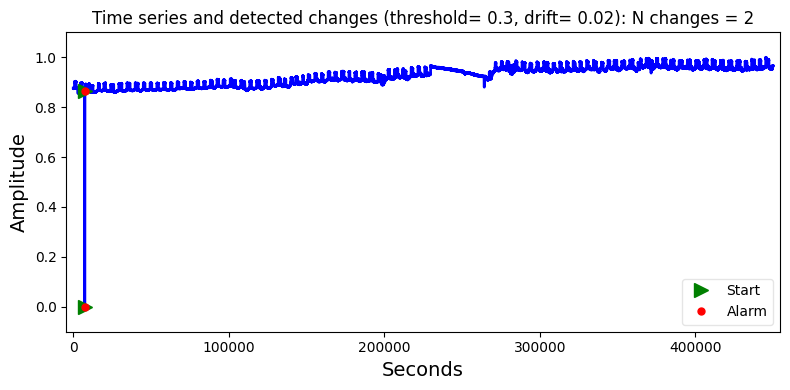

tai [7232 7431]


(array([7233, 7432]),
 array([7232, 7431]),
 array([], dtype=int64),
 array([], dtype=float64))

In [187]:
detect_cusum(x = df_attack_scaled['AIT202'], threshold = 0.3, drift = 0.02)

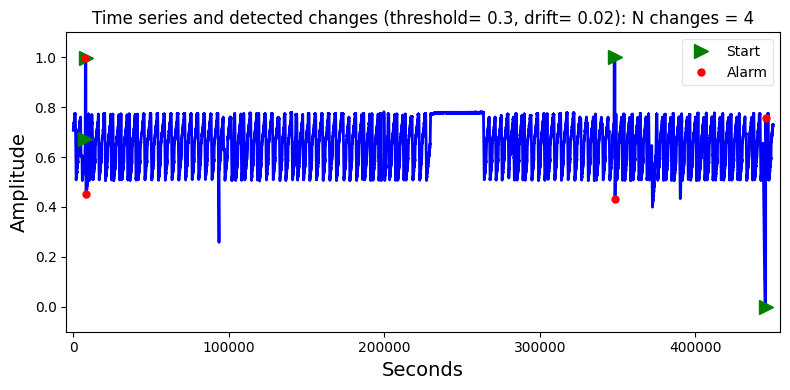

tai [  7684   8112 348314 445190]


(array([  7685,   8113, 348315, 445191]),
 array([  7684,   8112, 348314, 445190]),
 array([], dtype=int64),
 array([], dtype=float64))

In [188]:
detect_cusum(x = df_attack_scaled['LIT301'], threshold = 0.3, drift = 0.02)

In [220]:
Timestamp_attack[7684], Timestamp_attack[8112], Timestamp_attack[348314], Timestamp_attack[445190]

(Timestamp('2015-12-28 12:08:04'),
 Timestamp('2015-12-28 12:15:12'),
 Timestamp('2016-01-01 10:46:35'),
 Timestamp('2016-02-01 13:41:11'))

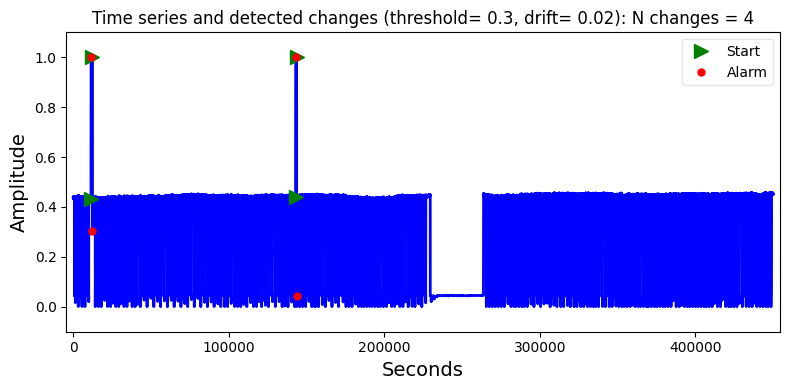

tai [ 11384  12354 142926 143610]


(array([ 11385,  12355, 142927, 143611]),
 array([ 11384,  12354, 142926, 143610]),
 array([], dtype=int64),
 array([], dtype=float64))

In [189]:
detect_cusum(x = df_attack_scaled['DPIT301'], threshold = 0.3, drift = 0.02)

In [226]:
Timestamp_attack[11384], Timestamp_attack[12354], Timestamp_attack[142929], Timestamp_attack[143610]

(Timestamp('2015-12-28 13:09:44'),
 Timestamp('2015-12-28 13:25:54'),
 Timestamp('2015-12-30 01:42:09'),
 Timestamp('2015-12-30 01:53:30'))

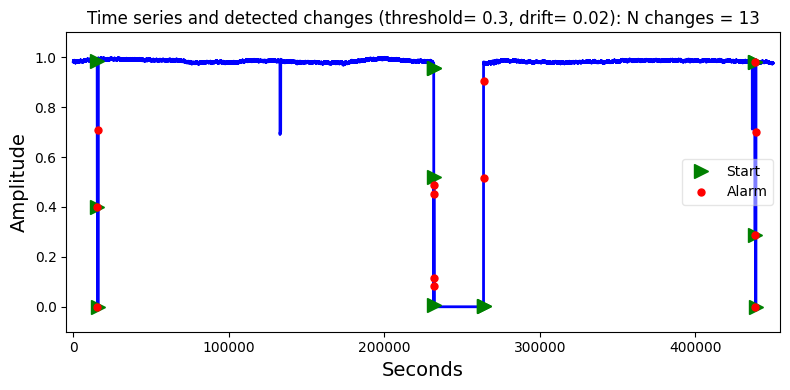

tai [ 15360  15521  16082 231759 231759 231854 231861 263795 263795 438183
 438583 438658 438954]


(array([ 15361,  15522,  16083, 231763, 231766, 231859, 231866, 263800,
        263804, 438184, 438584, 438659, 438955]),
 array([ 15360,  15521,  16082, 231759, 231759, 231854, 231861, 263795,
        263795, 438183, 438583, 438658, 438954]),
 array([], dtype=int64),
 array([], dtype=float64))

In [190]:
detect_cusum(x = df_attack_scaled['FIT401'], threshold = 0.3, drift = 0.02)

In [228]:
Timestamp_attack[15360], Timestamp_attack[15521], Timestamp_attack[16082], Timestamp_attack[231759],Timestamp_attack[231759], Timestamp_attack[231854],Timestamp_attack[231861], Timestamp_attack[263795],Timestamp_attack[438183]     

(Timestamp('2015-12-28 14:16:00'),
 Timestamp('2015-12-28 14:18:41'),
 Timestamp('2015-12-28 14:28:02'),
 Timestamp('2015-12-31 02:22:39'),
 Timestamp('2015-12-31 02:22:39'),
 Timestamp('2015-12-31 02:24:14'),
 Timestamp('2015-12-31 02:24:21'),
 Timestamp('2015-12-31 11:16:35'),
 Timestamp('2016-02-01 11:44:24'))

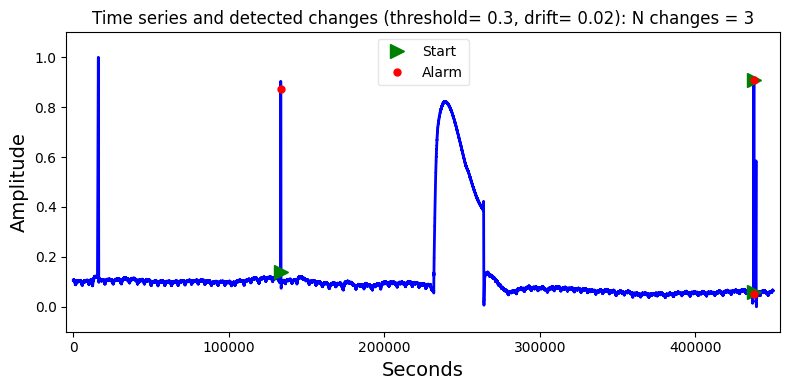

tai [133361 437454 437734]


(array([133362, 437455, 437735]),
 array([133361, 437454, 437734]),
 array([], dtype=int64),
 array([], dtype=float64))

In [191]:
detect_cusum(x = df_attack_scaled['AIT502'], threshold = 0.3, drift = 0.02)

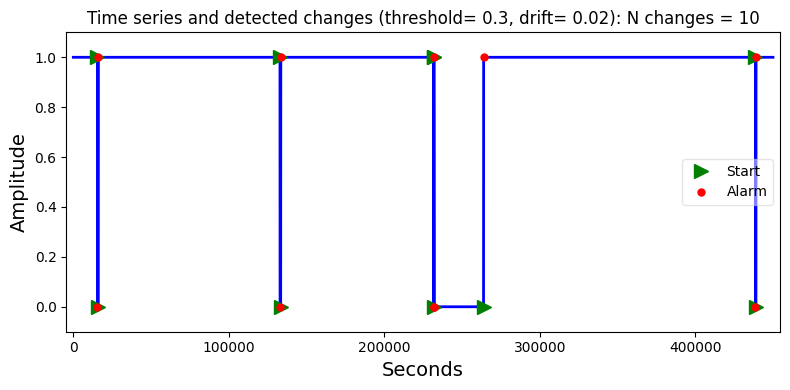

tai [ 15521  16083 132893 133361 231755 231853 231855 263794 438659 438954]


(array([ 15522,  16084, 132894, 133362, 231756, 231854, 231856, 263795,
        438660, 438955]),
 array([ 15521,  16083, 132893, 133361, 231755, 231853, 231855, 263794,
        438659, 438954]),
 array([], dtype=int64),
 array([], dtype=float64))

In [192]:
detect_cusum(x = df_attack_scaled['UV401'], threshold = 0.3, drift = 0.02)

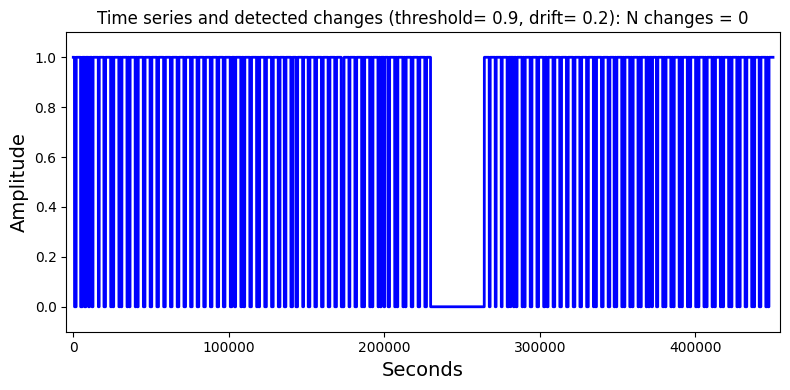

tai []


(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=float64))

In [195]:
detect_cusum(x = df_attack_scaled['P203'], threshold = 0.9, drift = 0.2)

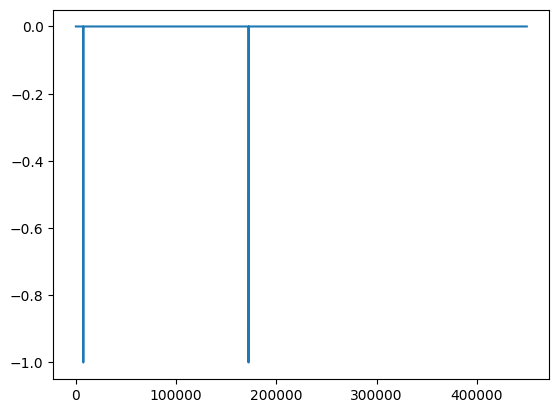

In [198]:
plt.plot(df_attack_scaled['P203'] - df_attack_scaled['P205'])

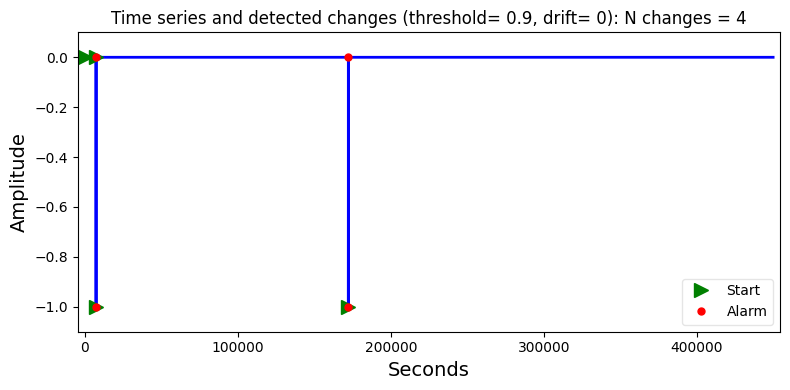

tai [     0   7234   7432 172268]


(array([  7234,   7432, 172268, 172269]),
 array([     0,   7234,   7432, 172268]),
 array([], dtype=int64),
 array([], dtype=float64))

In [202]:
detect_cusum(x = (df_attack_scaled['P203'] - df_attack_scaled['P205']), threshold = 0.9, drift = 0)

In [186]:
df_attack_scaled.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Label'],
      dtype='object')

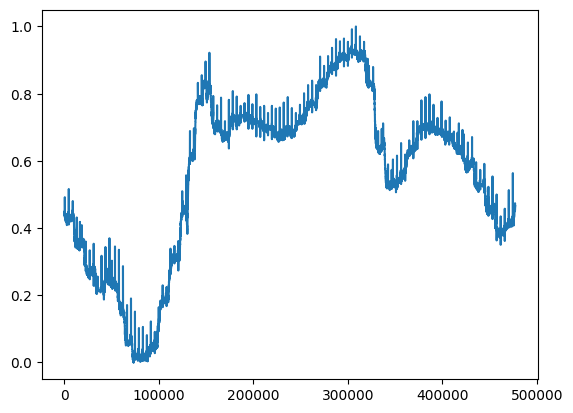

In [83]:
plt.plot(df_scaled['AIT201'])

In [ ]:
for j in range(df_attack_scaled.shape[1]):
    detect_cusum(x=(df_attack_scaled.iloc[:,j].values), threshold = 0.5, drift = 0.4)

## LOF

In [136]:
from sklearn.neighbors import LocalOutlierFactor

In [138]:
lof_novel = LocalOutlierFactor(n_neighbors = 7, novelty=True).fit(df_attack_scaled[['P101','P102']])

In [139]:
lof_pred = lof_novel.predict(df_attack_scaled[['P101','P102']])
lof_pred = [1 if i == -1 else 0 for i in lof_pred]

/Users/vincevillegas/miniconda3/envs/SWAT/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


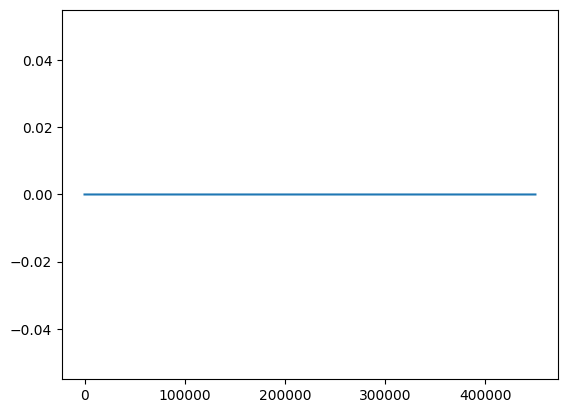

In [141]:
plt.plot(lof_pred)
#plt.plot(Label)
plt.show()

In [105]:
from sklearn.ensemble import IsolationForest

In [109]:
isoF_novel = IsolationForest(contamination = 0.2).fit(df_scaled)

/Users/vincevillegas/miniconda3/envs/SWAT/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [118]:
isoF_pred = IsolationForest(contamination = 0.05).fit_predict(df_attack_scaled.iloc[:,:-1])

/Users/vincevillegas/miniconda3/envs/SWAT/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


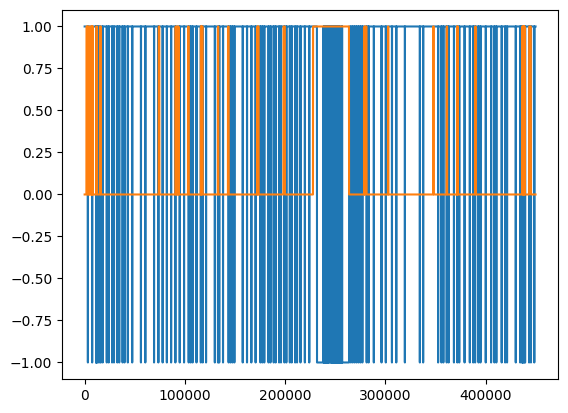

In [120]:
plt.plot(isoF_pred)
plt.plot(Label)
plt.show()

In [213]:
Timestamp_attack.head()

0   2015-12-28 10:00:00
1   2015-12-28 10:00:01
2   2015-12-28 10:00:02
3   2015-12-28 10:00:03
4   2015-12-28 10:00:04
Name: Timestamp, dtype: datetime64[ns]